In [298]:
import csv
from math import log
import gensim.parsing.preprocessing as prep
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import numpy as np
import itertools
from math import log
from sklearn.model_selection import StratifiedKFold

In [407]:
def str2subset(s, l):
    return [s[i:i+l] for i in range(len(s)-l+1)]


def str2subsets_dict(s, min_l, max_l):
    assert max_l <= len(s)
    sets = {}
    for i in range(min_l, max_l+1):
        sets[i] = str2subset(s, i)
#     return list(itertools.chain.from_iterable(list(sets.values())))
    return sets


def str2subsets_str(s, min_l, max_l):
#     assert max_l <= len(s)
    sets = []
    for i in range(min_l, min(max_l+1, len(s))):
        sets += str2subset(s, i)
    return ' '.join(sets)


def get_docs(f, upper, min_len = 50):
    s = ''
    c = f.read(1)
    while c:
        if c not in 'acgtACGT':
            c = f.read(1)
            continue
        if c.isupper() != upper:
            break
        s += c
        c = f.read(1)
    docs = []
    k = 0
    while k+min_len < len(s):
        docs.append(s[k:k+min_len])
        k += min_len
    if len(docs) > 0:
        docs[-1] += s[k:-1]
    else:
        docs.append(s)
    return docs, c


def make_docs(filePath):
    exons = []
    introns = []
    f = open(filePath)
    c = f.read(1)
    while (c):
        upper = c.isupper()
        pair = get_docs(f, upper, 200)
        doc = c + pair[0][0]
        if upper:
            exons.append(doc)
        else:
            introns.append(doc)
        for i in range(1, len(pair[0])):
            doc = pair[0][i]
            if upper:
                exons.append(doc)
            else:
                introns.append(doc)
        c = pair[1]
    return exons, introns


def get_subset_docs(filePath, min_l, max_l):
    exons, introns = make_docs(filePath)
    exons = [str2subsets_str(s, min_l, max_l) for s in exons]
    introns = [str2subsets_str(s, min_l, max_l) for s in introns]
    return exons, introns

In [335]:
exons, introns = get_subset_docs(r"C:\Users\admin\PycharmProjects\dna\files\dna.txt", 1, 7)

In [166]:
data = pd.DataFrame(data=np.array([exons+introns,
                          np.concatenate((np.ones_like(exons, dtype=np.int8),
                                          np.zeros_like(introns, dtype=np.int8))).tolist()]).T,
                    columns=['dna', 'exon'])

In [292]:
data.head()

,dna,exon
0,G T G G C G C G A G C T T C T G A A A C T A G ...,1
1,A C T T A T T T A C C A A G C A T T G G A G G ...,1
2,A T T T A G G A C C A A T A A G T C T T A A T ...,1
3,T A C G A A C C A A A C C T A T T T A A A A C ...,1
4,G A A G G A A T G T T C C C A A T A G T A G A ...,1


In [168]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

In [169]:
kf = KFold(n_splits=10, shuffle=True)
f1_scores = []
for train, test in kf.split(data):
    X = data['dna'][train]
    Y = data['exon'][train]
    text_clf.fit(data['dna'], data['exon'])
    predicted = text_clf.predict(data['dna'][test])
    f1_scores.append(f1_score(data['exon'][test], predicted, average='micro'))
print("F-score: ", sum(f1_scores)/len(f1_scores))

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

F-score:  0.876006464883926


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [187]:
important_features = []
with open(r"C:\Users\admin\PycharmProjects\dna\files\important.features.deep-7.m-100.prob-find-0.999.prob-90.0.threshold-2.0.txt", 'r') as f:
    for line in f:
        if line[0] != 'e':
            important_features.append(line.split()[0])

In [188]:
exons_only_important = []
for s in exons:
    s_imp = []
    for ss in s.split():
        if ss.lower() in important_features:
            s_imp.append(ss)
    exons_only_important.append(' '.join(s_imp))
    
introns_only_important = []
for s in introns:
    s_imp = []
    for ss in s.split():
        if ss in important_features:
            s_imp.append(ss)
    introns_only_important.append(' '.join(s_imp))

In [190]:
data_imp = pd.DataFrame(data=np.array([exons_only_important+introns_only_important,
                          np.concatenate((np.ones_like(exons_only_important, dtype=np.int8),
                                          np.zeros_like(introns_only_important, dtype=np.int8))).tolist()]).T,
                    columns=['dna', 'exon'])
data_imp.head()

,dna,exon
0,TGGG TAGGC CACTG GAAGC TTTTT AAAGA AAGAA TTCTG...,1
1,AAAGA TTTTT TTTTT TTTTT ATCCAA TTTTTT TTTTAA C...,1
2,GAAGA AAGAA GAAGC GAAGA AAGAA TACGA ACGAA AAAG...,1
3,TCCC GAAAA CAGATGA,1
4,AAAGA GTTCTAC ATAAGTC,1


In [191]:
f1_scores_imp = []
for train, test in kf.split(data_imp):
    X = data_imp['dna'][train]
    Y = data_imp['exon'][train]
    text_clf.fit(data_imp['dna'], data_imp['exon'])
    predicted = text_clf.predict(data_imp['dna'][test])
    f1_scores_imp.append(f1_score(data_imp['exon'][test], predicted, average='micro'))
print("F-score: ", sum(f1_scores_imp)/len(f1_scores_imp))

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

F-score:  0.9686411149825783


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [427]:
def get_f_score(prob, treshold, clf):
    important_features = []
    with open(r"C:\Users\admin\PycharmProjects\dna\files\important.features.deep-7.m-100.prob-find-0.999."
              +"prob-"+prob
              +".threshold-"+treshold
              +".txt", 'r') as f:
        for line in f:
            if line[0] != 'e':
                important_features.append(line.split()[0])
                
    exons_only_important = []
    for s in exons:
        s_imp = []
        for ss in s.split():
            if ss.lower() in important_features:
                s_imp.append(ss)
        exons_only_important.append(' '.join(s_imp))

    introns_only_important = []
    for s in introns:
        s_imp = []
        for ss in s.split():
            if ss in important_features:
                s_imp.append(ss)
        introns_only_important.append(' '.join(s_imp))
        
    data_imp = pd.DataFrame(data=np.array([exons_only_important+introns_only_important,
                          np.concatenate((np.ones_like(exons_only_important, dtype=np.int8),
                                          np.zeros_like(introns_only_important, dtype=np.int8))).tolist()]).T,
                    columns=['dna', 'exon'])
    
#     _clf = Pipeline([('vect', CountVectorizer()),
#                      ('tfidf', TfidfTransformer()),
#                      ('clf', MultinomialNB())])
    f1_scores_imp = []
    for train, test in skf.split(data_imp.dna, data_imp.exon):
        X = data_imp['dna'][train]
        Y = data_imp['exon'][train]
        clf.fit(X, Y)
        predicted = clf.predict(data_imp['dna'][test])
        f1_scores_imp.append(f1_score(data_imp['exon'][test], predicted, average='micro'))
        
    return sum(f1_scores_imp)/len(f1_scores_imp), clf
#     return np.mean(cross_val_score(text_clf, data_imp.dna, data_imp.exon, cv=5, n_jobs=4)), text_clf

In [ ]:
f_scores = []
prob_treshold_dict = {}
with open(r"C:\Users\admin\PycharmProjects\dna\files\output_probs_nh.txt", 'r') as prob_treshold_f:
    for line in prob_treshold_f:
        prob = line.split()[0]
        treshold = line.split()[1]
        prob_treshold_dict.setdefault(float(prob), []).append(float(treshold))
        f_scores.append([float(prob), float(treshold), get_f_score(prob, treshold)[0]])

In [200]:
f_scores

[[70.0, 1.5, 0.8550522648083623],
 [70.0, 1.75, 0.8597560975609756],
 [70.0, 2.0, 0.862253193960511],
 [70.0, 2.25, 0.9710220673635307],
 [70.0, 2.5, 0.9830429732868756],
 [70.0, 2.75, 0.9806620209059232],
 [70.0, 3.0, 0.9879790940766551],
 [71.0, 1.5, 0.8546457607433217],
 [71.0, 1.75, 0.8599303135888501],
 [71.0, 2.0, 0.9541811846689896],
 [71.0, 2.25, 0.975725900116144],
 [71.0, 2.5, 0.9807200929152149],
 [71.0, 2.75, 0.9807200929152149],
 [71.0, 3.0, 0.9903600464576074],
 [72.0, 1.5, 0.8552845528455284],
 [72.0, 1.75, 0.8573170731707316],
 [72.0, 2.0, 0.963937282229965],
 [72.0, 2.25, 0.975725900116144],
 [72.0, 2.5, 0.9830429732868758],
 [72.0, 2.75, 0.9854819976771196],
 [72.0, 3.0, 0.9904181184668989],
 [73.0, 1.5, 0.8552845528455284],
 [73.0, 1.75, 0.9349593495934959],
 [73.0, 2.0, 0.9685830429732867],
 [73.0, 2.25, 0.9783391405342625],
 [73.0, 2.5, 0.9829849012775842],
 [73.0, 2.75, 0.9807200929152149],
 [74.0, 1.5, 0.8842624854819977],
 [74.0, 1.75, 0.9419279907084785],
 [74.

In [285]:
prob_treshold_dict = {}
with open(r"C:\Users\admin\PycharmProjects\dna\files\output_probs_nh.txt", 'r') as prob_treshold_f:
    for line in prob_treshold_f:
        prob = line.split()[0]
        treshold = line.split()[1]
        prob_treshold_dict.setdefault(float(prob), []).append(float(treshold))

In [339]:
prob_treshold_dict

{50.0: [1.5,
  1.75,
  2.0,
  2.25,
  2.5,
  2.75,
  3.0,
  3.25,
  3.5,
  3.75,
  4.0,
  4.25,
  4.5,
  4.75,
  5.0,
  5.25,
  5.5,
  5.75,
  6.0,
  6.25],
 51.0: [1.5,
  1.75,
  2.0,
  2.25,
  2.5,
  2.75,
  3.0,
  3.25,
  3.5,
  3.75,
  4.0,
  4.25,
  4.5,
  4.75,
  5.0,
  5.25,
  5.5,
  5.75,
  6.0,
  6.25],
 52.0: [1.5,
  1.75,
  2.0,
  2.25,
  2.5,
  2.75,
  3.0,
  3.25,
  3.5,
  3.75,
  4.0,
  4.25,
  4.5,
  4.75,
  5.0,
  5.25,
  5.5,
  5.75,
  6.0],
 53.0: [1.5,
  1.75,
  2.0,
  2.25,
  2.5,
  2.75,
  3.0,
  3.25,
  3.5,
  3.75,
  4.0,
  4.25,
  4.5,
  4.75,
  5.0,
  5.25,
  5.5],
 54.0: [1.5,
  1.75,
  2.0,
  2.25,
  2.5,
  2.75,
  3.0,
  3.25,
  3.5,
  3.75,
  4.0,
  4.25,
  4.5,
  4.75,
  5.0,
  5.25],
 55.0: [1.5,
  1.75,
  2.0,
  2.25,
  2.5,
  2.75,
  3.0,
  3.25,
  3.5,
  3.75,
  4.0,
  4.25,
  4.5,
  4.75,
  5.0],
 56.0: [1.5,
  1.75,
  2.0,
  2.25,
  2.5,
  2.75,
  3.0,
  3.25,
  3.5,
  3.75,
  4.0,
  4.25,
  4.5,
  4.75],
 57.0: [1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0,

In [340]:
f_scores = []
for key, value in prob_treshold_dict.items():
    prob = str(key)
    treshold = str(max(value))
    f_scores.append([float(prob), float(treshold), get_f_score(prob, treshold)[0]])
    print([float(prob), float(treshold), get_f_score(prob, treshold)[0]])
f_scores

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[50.0, 6.25, 0.8550522648083623]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[51.0, 6.25, 0.8550522648083623]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[52.0, 6.0, 0.8550522648083623]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[53.0, 5.5, 0.8550522648083623]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[54.0, 5.25, 0.8550522648083623]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[55.0, 5.0, 0.8550522648083623]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[56.0, 4.75, 0.8550522648083623]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[57.0, 4.5, 0.8550522648083623]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[58.0, 4.25, 0.8550522648083623]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[59.0, 4.0, 0.8550522648083623]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[60.0, 3.75, 0.8550522648083623]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[61.0, 3.75, 0.8550522648083623]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[62.0, 3.75, 0.9179442508710803]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[63.0, 3.75, 0.9082462253193961]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[64.0, 3.5, 0.9202090592334494]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[65.0, 3.5, 0.9128339140534264]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[66.0, 3.5, 0.9155052264808363]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[67.0, 3.25, 0.9153890824622533]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[68.0, 3.25, 0.9056329849012776]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[69.0, 3.25, 0.9372822299651569]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[70.0, 3.0, 0.9275842044134727]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[71.0, 3.0, 0.9443089430894309]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[72.0, 3.0, 0.9396051103368176]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[73.0, 2.75, 0.9467479674796747]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[74.0, 2.75, 0.9613240418118467]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[75.0, 2.75, 0.9516840882694542]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[76.0, 2.75, 0.944425087108014]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[77.0, 2.5, 0.9494192799070846]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[78.0, 2.5, 0.9397793263646923]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[79.0, 2.5, 0.9493031358885018]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[80.0, 2.5, 0.9541811846689896]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[81.0, 2.5, 0.9468641114982578]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[82.0, 2.25, 0.9491289198606271]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[83.0, 2.25, 0.9588850174216029]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[84.0, 2.25, 0.954123112659698]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[85.0, 2.25, 0.9518002322880372]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[86.0, 2.0, 0.9564459930313589]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[87.0, 2.0, 0.9466898954703833]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[88.0, 2.0, 0.9422183507549361]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[89.0, 2.0, 0.9468641114982578]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[90.0, 2.0, 0.9467479674796749]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[91.0, 1.75, 0.9250871080139375]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[92.0, 1.75, 0.9225319396051104]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[93.0, 1.75, 0.9203832752613241]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[94.0, 1.75, 0.9203252032520327]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[95.0, 1.5, 0.8766550522648083]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[96.0, 1.5, 0.8743321718931474]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[97.0, 1.5, 0.8768292682926828]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[98.0, 1.5, 0.8621951219512194]


[[50.0, 6.25, 0.8550522648083623],
 [51.0, 6.25, 0.8550522648083623],
 [52.0, 6.0, 0.8550522648083623],
 [53.0, 5.5, 0.8550522648083623],
 [54.0, 5.25, 0.8550522648083623],
 [55.0, 5.0, 0.8550522648083623],
 [56.0, 4.75, 0.8550522648083623],
 [57.0, 4.5, 0.8550522648083623],
 [58.0, 4.25, 0.8550522648083623],
 [59.0, 4.0, 0.8550522648083623],
 [60.0, 3.75, 0.8550522648083623],
 [61.0, 3.75, 0.8550522648083623],
 [62.0, 3.75, 0.9154471544715447],
 [63.0, 3.75, 0.9107433217189316],
 [64.0, 3.5, 0.9203832752613241],
 [65.0, 3.5, 0.9202090592334494],
 [66.0, 3.5, 0.9059233449477352],
 [67.0, 3.25, 0.9200348432055749],
 [68.0, 3.25, 0.9057491289198607],
 [69.0, 3.25, 0.9469221835075492],
 [70.0, 3.0, 0.9177700348432056],
 [71.0, 3.0, 0.9420441347270616],
 [72.0, 3.0, 0.94198606271777],
 [73.0, 2.75, 0.9394889663182345],
 [74.0, 2.75, 0.9444831591173054],
 [75.0, 2.75, 0.951800232288037],
 [76.0, 2.75, 0.954123112659698],
 [77.0, 2.5, 0.9540650406504065],
 [78.0, 2.5, 0.9371660859465738],
 [

In [355]:
from sklearn.base import clone
from copy import deepcopy
fscore, best_clf = get_f_score("88.0", "2.0")
best_clf = deepcopy(best_clf)
fscore

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

0.9517421602787456

In [299]:
exons, introns = make_docs(r"C:\Users\admin\PycharmProjects\dna\files\dna.txt")
data2 = pd.DataFrame(data=np.array([exons+introns,
                          np.concatenate((np.ones_like(exons, dtype=np.int8),
                                          np.zeros_like(introns, dtype=np.int8))).tolist()]).T,
                    columns=['dna', 'exon'])
data2.head()

,dna,exon
0,GTGGCGCGAGCTTCTGAAACTAGGCGGCAGAGGCGGAGCCGCTGTG...,1
1,ACTTATTTACCAAGCATTGGAGGAATATCGTAGGTAAAAATGCCTA...,1
2,ATTTAGGACCAATAAGTCTTAATTGGTTTGAAGAACTTTCTTCAGA...,1
3,GAAGGAATGTTCCCAATAGTAGACATAAAAGTCTTCGCACAGTGAA...,1
4,TCCTGTTGTTCTACAATGTACACATGTAACACCACAAAGAGATAAG...,1


In [304]:
skf = StratifiedKFold(n_splits=10, shuffle=True)
X = data2.dna
y = data2.exon

In [441]:
def get_entropy(p):
    assert p >=0 and p <= 1
    if p < 10e-10 or p > 1-10e-10:
        return 0
    return -p*log(p)-(1-p)*log(1-p)

def get_sum_entropy(dnas, important_features, clf):
    sum_len = sum([len(s) for s in dnas])
    probs = predict_many(dnas, important_features, clf)
    h = 0
    for i in range(len(dnas)):
        h += get_entropy(probs[i][0])*float(len(dnas[i]))/sum_len
    return h, probs

def get_important_features(prob, treshold):
    important_features = []
    with open(r"C:\Users\admin\PycharmProjects\dna\files\important.features.deep-7.m-100.prob-find-0.999."
              +"prob-"+prob
              +".threshold-"+treshold
              +".txt", 'r') as f:
        for line in f:
            if line[0] != 'e':
                important_features.append(line.split()[0])
    return important_features

def str2important_features(s:str, important_features):
    s_imp = []
    for ss in str2subsets_str(s, 1, 7).split():
        if ss.lower() in important_features:
            s_imp.append(ss)
    return ' '.join(s_imp)

def predict_one(s:str, important_features, clf):
    probs = clf.predict_proba([str2important_features(s, important_features)]).tolist()
    if probs[0][0] > probs[0][1]:
        return 0, probs
    else:
        return 1, probs
    
def predict_many(s_a, important_features, clf):
    return clf.predict_proba([str2important_features(s, important_features) for s in s_a]).tolist()

def optimal_split(s:str, important_features, clf, prob0 = 0):
    ig = 0
    h0 = 0
    if prob0 == 0:
        h0 = get_entropy(predict_one(s, important_features, clf)[1][0][0])
    else:
        h0 = get_entropy(prob0)
    i0 = 0
    probs0 = []
    for i in range(len(s)):
        h, probs = get_sum_entropy([s[:i], s[i:]], important_features, clf)
        h /= len(s)
        if h0 - h > ig:
            ig = h0 - h
            i0 = i
            probs0 = probs
    return s[:i0], s[i0:], probs0

def split_rec(s:str, important_features, clf, prob0 = 0):
    s1, s2, probs = optimal_split(s, important_features, clf, prob0)
    if len(s1) == 0:
        return [s2]
    return split_rec(s1, important_features, clf, probs[0][0]) + split_rec(s2, important_features, clf, probs[1][0])

In [380]:
test_dna = "agataaaaatagtaaagatattcatatttatacagctttacaagttgaaacatcctttca\
tttatgaagaattaaaaggggtaccctttttagagaaaaggagagcatgtaaacttcgag\
gaaattgatatgtataattttataaaacagggcttgcgcttttttttttttgagacagag\
tttcgctcttgttgcccaggctggagtgcaatggtgcaacctcggctcaccgcaacctcc\
tcctcccgagttcaagtgattctcctgcctcagcctgctgaatagctgggattacaggca\
tgtgccaccacacctggctacttttgtgttttttttacttttatatattttttttttgtt\
tagtagagacagggtttctccattttggtcaggctggtcttgaactcccgacctcagatg\
atctgcccgcctcagcctcccaaagtgctgggattacaggcgtgagccactgtgcctggc\
caggggttgtgctttttaaatttcaattttatttttgctaagtatttattctttgatag\
"
test_dna_2 = "TTCATGTTTTGGGAAAAGAACAGGCTTCACCTAAAAACGTAAAAATGGAAATTGGTAAAA\
CTGAAACTTTTTCTGATGTTCCTGTGAAAACAAATATAGAAGTTTGTTCTACTTACTCCA\
AAGATTCAGAAAACTACTTTGAAACAGAAGCAGTAGAAATTGCTAAAGCTTTTATGGAAG\
ATGATGAACTGACAGATTCTAAACTGCCAAGTCATGCCACACATTCTCTTTTTACATGTC\
CCGAAAATGAGGAAATGGTTTTGTCAAATTCAAGAATTGGAAAAAGAAGAGGAGAGCCCC\
TTATCTTAGTGGGAGAACCCTCAATCAAAAGAAACTTATTAAATGAATTTGACAGGATAATAGAAAATCAAG\
AAAAATCCTTAAAGGCTTCAAAAAGCACTCCAGATG\
GCACAATAAAAGATCGAAGATTGTTTATGCATCATGTTTCTTTAGAGCCGATTACCTGTG\
TACCCTTTCG"
optimal_split(test_dna + test_dna_2, get_important_features("88.0", "2.0"), best_clf)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


('',
 'agataaaaatagtaaagatattcatatttatacagctttacaagttgaaacatcctttcatttatgaagaattaaaaggggtaccctttttagagaaaaggagagcatgtaaacttcgaggaaattgatatgtataattttataaaacagggcttgcgcttttttttttttgagacagagtttcgctcttgttgcccaggctggagtgcaatggtgcaacctcggctcaccgcaacctcctcctcccgagttcaagtgattctcctgcctcagcctgctgaatagctgggattacaggcatgtgccaccacacctggctacttttgtgttttttttacttttatatattttttttttgtttagtagagacagggtttctccattttggtcaggctggtcttgaactcccgacctcagatgatctgcccgcctcagcctcccaaagtgctgggattacaggcgtgagccactgtgcctggccaggggttgtgctttttaaatttcaattttatttttgctaagtatttattctttgatagTTCATGTTTTGGGAAAAGAACAGGCTTCACCTAAAAACGTAAAAATGGAAATTGGTAAAACTGAAACTTTTTCTGATGTTCCTGTGAAAACAAATATAGAAGTTTGTTCTACTTACTCCAAAGATTCAGAAAACTACTTTGAAACAGAAGCAGTAGAAATTGCTAAAGCTTTTATGGAAGATGATGAACTGACAGATTCTAAACTGCCAAGTCATGCCACACATTCTCTTTTTACATGTCCCGAAAATGAGGAAATGGTTTTGTCAAATTCAAGAATTGGAAAAAGAAGAGGAGAGCCCCTTATCTTAGTGGGAGAACCCTCAATCAAAAGAAACTTATTAAATGAATTTGACAGGATAATAGAAAATCAAGAAAAATCCTTAAAGGCTTCAAAAAGCACTCCAGATGGCACAATAAAAGATCGAAGATTGTTTATGCATCATGTTTCTTTAGA

In [409]:
clf.predict_proba([str2important_features(ss, important_features) for ss in [test_dna, test_dna_2]])

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


array([[0.99743188, 0.00256812],
       [0.19168072, 0.80831928]])

In [415]:
len(s)

1017

In [425]:
for i in range(len(s)):
    s1 = s[:i]
    s2 = s[i:]
#     print(clf.predict_proba([str2important_features(ss, important_features) for ss in [s1, s2]]))
    print(get_sum_entropy([s1, s2], important_features, clf)[0], i)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


0.11189632282877857 0
0.11219291697971182 1
0.11248951113064506 2
0.11278610528157833 3
0.11308269943251159 4
0.11337929358344485 5
0.1136758877343781 6
0.11397248188531135 7
0.11426907603624463 8
0.11456567018717788 9
0.11486226433811114 10
0.1151588584890444 11
0.11545545263997765 12
0.11575204679091092 13
0.11435136941504458 14
0.1146496557609198 15
0.11494794210679501 16
0.11524622845267027 17
0.11711554472416585 18
0.11750111051035332 19
0.1178866762965408 20
0.11827224208272827 21
0.11865780786891572 22
0.11904337365510322 23
0.11942893944129068 24
0.11981450522747815 25
0.12020007101366564 26
0.1205856367998531 27
0.12097120258604058 28
0.12135676837222804 29
0.12174233415841551 30
0.122127899944603 31
0.12251346573079046 32
0.12289903151697792 33
0.1232845973031654 34
0.12367016308935289 35
0.12405572887554035 36
0.12444129466172783 37
0.1248268604479153 38
0.12521242623410275 39
0.12559799202029026 40
0.12598355780647771 41
0.1263691235926652 42
0.12675468937885265 43
0.127140

In [430]:
uni_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB(fit_prior=False)),
])
get_f_score("88.0", "2.0", uni_clf)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

(0.9106852497096399,
 Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
         strip...near_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False))]))

In [431]:
for i in range(len(s)):
    s1 = s[:i]
    s2 = s[i:]
#     print(clf.predict_proba([str2important_features(ss, important_features) for ss in [s1, s2]]))
    print(get_sum_entropy([s1, s2], important_features, uni_clf)[0], i)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


0.35719299562920975 0
0.3575233340608034 1
0.357853672492397 2
0.35818401092399066 3
0.3585143493555843 4
0.35884468778717793 5
0.3591750262187717 6
0.35950536465036526 7
0.3598357030819589 8
0.3601660415135526 9
0.36049637994514616 10
0.3608267183767398 11
0.3611570568083335 12
0.36148739523992707 13
0.3572784768689803 14
0.35761334098033715 15
0.3579482050916941 16
0.358283069203051 17
0.3582409228029429 18
0.3585548418858851 19
0.35886876096882725 20
0.35918268005176945 21
0.3594965991347116 22
0.3598105182176538 23
0.36012443730059596 24
0.36043835638353816 25
0.3607522754664803 26
0.36106619454942246 27
0.36138011363236466 28
0.3616940327153068 29
0.362007951798249 30
0.36232187088119117 31
0.36263578996413337 32
0.3629497090470755 33
0.3632636281300177 34
0.36357754721295993 35
0.3638914662959021 36
0.3642053853788443 37
0.3645193044617864 38
0.3648332235447286 39
0.36514714262767073 40
0.36546106171061293 41
0.3657749807935551 42
0.3660888998764973 43
0.3664028189594395 44
0.366

In [432]:
f_scores = []
for key, value in prob_treshold_dict.items():
    prob = str(key)
    treshold = str(max(value))
    f_scores.append([float(prob), float(treshold), get_f_score(prob, treshold, uni_clf)[0]])
f_scores

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

[[50.0, 6.25, 0.9105110336817654],
 [51.0, 6.25, 0.8890824622531939],
 [52.0, 6.0, 0.8887921022067363],
 [53.0, 5.5, 0.93472706155633],
 [54.0, 5.25, 0.9153890824622533],
 [55.0, 5.0, 0.9468641114982578],
 [56.0, 4.75, 0.946864111498258],
 [57.0, 4.5, 0.9369337979094077],
 [58.0, 4.25, 0.9416957026713124],
 [59.0, 4.0, 0.9470383275261323],
 [60.0, 3.75, 0.9493031358885018],
 [61.0, 3.75, 0.9421022067363533],
 [62.0, 3.75, 0.9275842044134727],
 [63.0, 3.75, 0.9178861788617887],
 [64.0, 3.5, 0.9418699186991871],
 [65.0, 3.5, 0.9273519163763065],
 [66.0, 3.5, 0.9346109175377467],
 [67.0, 3.25, 0.9495934959349593],
 [68.0, 3.25, 0.9445993031358885],
 [69.0, 3.25, 0.9343786295005808],
 [70.0, 3.0, 0.9540650406504065],
 [71.0, 3.0, 0.9324041811846691],
 [72.0, 3.0, 0.9348432055749128],
 [73.0, 2.75, 0.9396631823461092],
 [74.0, 2.75, 0.9540069686411149],
 [75.0, 2.75, 0.9468060394889661],
 [76.0, 2.75, 0.956562137049942],
 [77.0, 2.5, 0.9396051103368176],
 [78.0, 2.5, 0.9468060394889664],
 [

In [433]:
prob = "82.0"
treshold = "2.25"
best_clf = deepcopy(get_f_score(prob, treshold, uni_clf)[1])
optimal_split(test_dna + test_dna_2, get_important_features(prob, treshold), best_clf)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Program Files

('agataaaaatagtaaagatattcatatttatacagctttacaagttgaaacatcctttcatttatgaagaattaaaaggggtaccctttttagagaaaaggagagcatgtaaacttcgaggaaattgatatgtataattttataaaacagggcttgcgcttttttttttttgagacagagtttcgctcttgttgcccaggctggagtgcaatggtgcaacctcggctcaccgcaacctcctcctcccgagttcaagtgattctcctgcctcagcctgctgaatagctgggattacaggcatgtgccaccacacctggctacttttgtgttttttttacttttatatattttttttttgtttagtagagacagggtttctccattttggtcaggctggtcttgaactcccgacctcagatgatctgcccgcctcagcctcccaaagtgctgggattacaggcgtgagccactgtgcctggccaggggttgtgctttttaaatttcaattttatttttgctaagtatttattctttgatagTTCATGTTTTGGGAAAAGAACAGGCTT',
 'CACCTAAAAACGTAAAAATGGAAATTGGTAAAACTGAAACTTTTTCTGATGTTCCTGTGAAAACAAATATAGAAGTTTGTTCTACTTACTCCAAAGATTCAGAAAACTACTTTGAAACAGAAGCAGTAGAAATTGCTAAAGCTTTTATGGAAGATGATGAACTGACAGATTCTAAACTGCCAAGTCATGCCACACATTCTCTTTTTACATGTCCCGAAAATGAGGAAATGGTTTTGTCAAATTCAAGAATTGGAAAAAGAAGAGGAGAGCCCCTTATCTTAGTGGGAGAACCCTCAATCAAAAGAAACTTATTAAATGAATTTGACAGGATAATAGAAAATCAAGAAAAATCCTTAAAGGCTTCAAAAAGCACTCCAGATGGCACAATAAAAGATCGAAGATTGTTTATGCATCATGTTTCTTTAGA

In [445]:
test_dna_3 = "aagaattaagaaaattgttacttttctaattccttttctgtgccttgcttttctgttcac\
accagtattaacagcaatgaaattttttcaattttattttccaataaaaattactttgag\
ttttttttatggtagctagctacttccttgacctagatactaattttgattgagttggta\
actattattaaaaaaacaacttaggtctaatttatcttgagctaaaaaatgtaataactg\
aaaaatagagcatatttaggattctttctgctttaaatttgacattcagttattttcatg\
taatttgtgttttgagcactaccttttaattaatttatttatttttattttttagagact\
gtctcattctgttacctagtctggagtgcactagtgtgatctcagctcaccgtagcctca\
ccctcctgggctcaagcagtccttgcacctcaccctcctgagtaactggcaccacaggca\
tacaccaccacacccagctaatttttatttttcatagagtcatggtctcactatgttgcc\
caggctagtctcgaactcctgggctcaagcagtcttcctgcctcagcctcccaaaagtgc\
tgagattacaggcatgagccactgtgcccaaacactacctttttaacttagtgaaaaata\
tttagtgaatgtgattgatggtactttaattttgtcactttgtgtttttatgtttag"

In [444]:
%%time

split_rec(test_dna + test_dna_2 + test_dna_3, get_important_features(prob, treshold), best_clf)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Wall time: 1min 59s


['agataaaaatagtaaagatattcatatttatacagctttacaagttgaaacatcctttcatttatgaagaattaaaaggggtaccctttttagagaaaaggagagcatgtaaacttcgaggaaattgatatgtataattttataaaacagggcttgcgcttttttttttttgagacagagtttcgctcttgttgcccaggctggagtgcaatggtgcaacctcggctcaccgcaacctcctcctcccgagttcaagtgattctcctgcctcagcctgctgaatagctgggattacaggcatgtgccaccacacctggctacttttgtgttttttttacttttatatattttttttttgtttagtagagacagggtttctccattttggtcaggctggtcttgaactcccgacctcagatgatctgcccgcctcagcctcccaaagtgctgggattacaggcgtgagccactgtgcctggccaggggttgtgctttttaaatttcaattttatttttgctaagtatttattctttgatagTTCATGTTTTGGGAAAAGAACAGGCTTCACCTAAAAACGTAAAAATGGAAATTGGTAAAACTGAAACTTTTTCTGATGTTCCTGTGAAAACAAATATAGAAGTTTGTTCTACTTACTCCAAAGATTCAGAAAACTACTTTGAAACAGAAGCAGTAGAAATTGCTAAAGCTTTTATGGAAGATGATGAACTGACAGATTCTAAACTGCCAAGTCATGCCACACATTCTCTTTTTACATGTCCCGAAAATGAGGAAATGGTTTTGTCAAATTCAAGAATTGGAAAAAGAAGAGGAGAGCCCCTTATCTTAGTGGGAGAACCCTCAATCAAAAGAAACTTATTAAATGAATTTGACAGGATAATAGAAAATCAAGAAAAATCCTTAAAGGCTTCAAAAAGCACTCCAGATGGCACAATAAAAGATCGAAGATTGTTTATGCATCATGTTTCTTTAGAGCCGA

In [449]:
s = test_dna + test_dna_2 + test_dna_3
ig = 0
h0 = get_entropy(predict_one(s, important_features, clf)[1][0][0])
i0 = 0
prob_a = []

for i in range(len(s)):
    h, probs = get_sum_entropy([s[:i], s[i:]], important_features, best_clf)
    h /= len(s)
    print(h, probs[0][0], probs[1][0], i)
    if h0 - h > ig:
        ig = h0 - h
        i0 = i
        probs0 = probs

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


2.241605795960773e-05 0.5 0.9935681426791506 0
2.2633660497378665e-05 0.5 0.9935681426791506 1
2.28512630351496e-05 0.5 0.9935681426791506 2
2.3068865572920532e-05 0.5 0.9935681426791506 3
2.3286468110691465e-05 0.5 0.9935681426791506 4
2.3504070648462406e-05 0.5 0.9935681426791506 5
2.3721673186233336e-05 0.5 0.9935681426791506 6
2.3939275724004276e-05 0.5 0.9935681426791506 7
2.4156878261775213e-05 0.5 0.9935681426791506 8
2.4374480799546143e-05 0.5 0.9935681426791506 9
2.459208333731708e-05 0.5 0.9935681426791506 10
2.4809685875088016e-05 0.5 0.9935681426791506 11
2.502728841285895e-05 0.5 0.9935681426791506 12
2.5244890950629883e-05 0.5 0.9935681426791506 13
2.523238493678597e-05 0.5 0.9936478557001619 14
2.5450121258598542e-05 0.5 0.9936478557001619 15
2.566785758041111e-05 0.5 0.9936478557001619 16
2.588559390222369e-05 0.5 0.9936478557001619 17
2.6102278068585517e-05 0.49062599727826783 0.9936478557001619 18
2.631995593731749e-05 0.49062599727826783 0.9936478557001619 19
2.65376

In [455]:
from scipy.signal import argrelextrema

s = test_dna + test_dna_2 + test_dna_3
prob_a = []

for i in range(len(s)):
#     h, probs = get_sum_entropy([s[:i], s[i:]], important_features, best_clf)
    probs = predict_many([s[:i], s[i:]], important_features, best_clf)
    prob_a.append(probs[0][1])
#     h /= len(s)
#     print(h, probs[0][0], probs[1][0], i)
#     if h0 - h > ig:
#         ig = h0 - h
#         i0 = i
#         probs0 = probs

print(argrelextrema(np.array(prob_a), np.greater))
print(argrelextrema(np.array(prob_a), np.less))

C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(array([1104], dtype=int64),)
(array([ 167,  332,  351,  515, 1362, 1368, 1528, 1725], dtype=int64),)


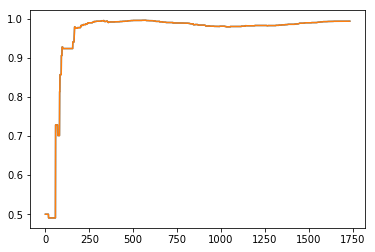

In [454]:
from matplotlib import pyplot as plt
plt.plot(prob_a)
plt.show()

In [474]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

#     if x.ndim != 1:
#         raise ValueError, "smooth only accepts 1 dimension arrays."

#     if x.size < window_len:
#         raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


#     if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
#         raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

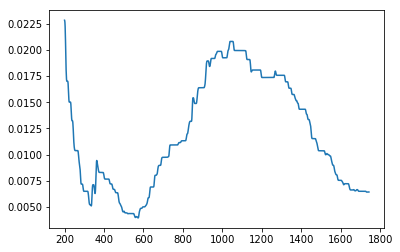

In [482]:
smoothed = smooth(prob_a,window_len=10)
plt.plot(list(range(200, len(smoothed))), smoothed[200:])
plt.show()

In [522]:
print(argrelextrema(np.array(prob_a), np.greater))
print(argrelextrema(np.array(prob_a), np.less))

(array([1104], dtype=int64),)
(array([ 167,  332,  351,  515, 1362, 1368, 1528, 1725], dtype=int64),)


In [585]:
maxs = []
mins = []
N = 100
print("mins:")
for mi in range(N,len(prob_a)):
    if prob_a[mi] <= min(prob_a[mi-N:mi]) and prob_a[mi] <= min(prob_a[mi+1:mi+N+1]):
        print(mi)
        mins.append(mi)
print("\nmaxs:")
for ma in range(N,len(prob_a)):
    if prob_a[ma] >= max(prob_a[ma-N:ma]) and prob_a[ma] >= max(prob_a[ma+1:ma+N+1]):
        print(ma)
        maxs.append(ma)

mins:
332
565
566
567
568
569
570
571
572
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1725

maxs:
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052


In [588]:
mins_i = [0]
for i in range(len(mins)-1):
    if mins[i+1] - mins[i] > N:
        mins_i.append(i+1)
mins_i.append(len(mins))
mins_smoothed = []
for j in range(0, len(mins_i)-1):
    print(j, mins_i[j], mins[mins_i[j]])
    mins_smoothed.append(int(np.mean(mins[mins_i[j]: mins_i[j+1]])))
mins_smoothed

0 0 332
1 1 565
2 9 1192
3 30 1725


[332, 568, 1202, 1725]

In [589]:
maxs_i = [0]
for i in range(len(maxs)-1):
    if maxs[i+1] - maxs[i] > N:
        maxs_i.append(i+1)
maxs_i.append(len(maxs)-1)
maxs_smoothed = []
for j in range(0, len(maxs_i)-1):
    print(j, maxs_i[j], maxs[maxs_i[j]])
    maxs_smoothed.append(int(np.mean(maxs[maxs_i[j]: maxs_i[j+1]])))
maxs_smoothed

0 0 1031


[1041]

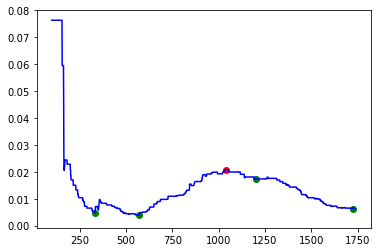

In [590]:
plt.plot(list(range(N, len(prob_a))), prob_a[N:], c='blue')
plt.scatter(maxs_smoothed, [prob_a[i] for i in maxs_smoothed], c='red')
plt.scatter(mins_smoothed, [prob_a[i] for i in mins_smoothed], c='green')
plt.show()

In [592]:
sorted_maxs_mins = sorted([(ma, "max") for ma in maxs_smoothed] + [(mi, "min") for mi in mins_smoothed])
sorted_maxs_mins

[(332, 'min'), (568, 'min'), (1041, 'max'), (1202, 'min'), (1725, 'min')]

In [ ]:
final_extremums = []
for i in range(len(sorted_maxs_mins)-1):
    if sorted_maxs_mins[i][1] == sorted_maxs_mins[i+1][1] == "max":
        if prob_a[sorted_maxs_mins[i][0]] > prob_a[sorted_maxs_mins[i+1][0]]:
            